##### Project 2 - Big-Scale Analysis 
##### Team ROLEX - Samuel Lew, Alexandre Lang, Samy Bouzerda, Alix Muller
-------
# Kaggle: Real or Not? NLP with Disaster Tweets
-------

# 0. Dataset
This competition's Dataset shows a set of tweets divided into a training and a test set. The training set has a column named 'target' that permits to identify if the tweet contains an infomation about a disaster or not.

For example, here are one tweet about a disaster and another not:

In [110]:
# A disaster tweet
disaster_tweet = train[train['Target'] == 1]['Tweet text']
disaster_tweet.values[1]

'I can probably skip on these basic life maintenance things for a few days. (cut to burning buildings people screaming in the streets)'

In [111]:
# A tweet not concerning a disaster
non_disaster_tweet = train[train['Target'] == 0]['Tweet text']
non_disaster_tweet.values[1]

"What the hell is wrong with people?!communication!  Rule with an iron fist ticket to disaster.  Can't swing one day and not the next."

In this competition, people have to create a machine learning model to predict whether the tweets test set mention a disaster or not. This challenge is a binary classification problem.

# I. Importing libraries

In [106]:
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alixm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# II. EDA

## 1. Training set

### Data loading

In [107]:
train = pd.read_csv('../data/train.csv')
train = train.sample(frac=1, replace=False)
train = train[['id', 'keyword', 'location', 'text', 'target']]
train.shape

(7613, 5)

In [108]:
train.columns = ['ID', 'Keyword', 'Location', 'Tweet text', 'Target']
train.head()

,ID,Keyword,Location,Tweet text,Target
4012,5698,floods,"New York, USA",love when drake floods instagram. makes you fe...,0
2803,4030,disaster,"Fort Worth, Texas",What the hell is wrong with people?!communicat...,0
877,1271,blood,North Jersey,@olrules Welcome - Read a free chapter of my n...,0
3762,5344,fire,Makai,@DaughterofNai Tenshi activated Yuki's fire card!,0
3531,5047,eyewitness,NaN,Monkeys Abused by Notorious Laboratory Dealer ...,0


### Distribution of the target column

In [109]:
#when the target = 1 it means the the tweet is about a disaster
train_yes = train.query('Target == 1')
yes_count = 0
for row in train_yes.iterrows():
    yes_count += 1
print(f'There are {yes_count} tweets about disasters (Target = 0).')

#when the target = 0 it means the the tweet is not about a disaster
train_no = train.query('Target == 0')
no_count = 0
for row in train_no.iterrows():
    no_count += 1
print(f'There are {no_count} tweets that are not about disasters (Target = 1).')

There are 3271 tweets about disasters (Target = 0).
There are 4342 tweets that are not about disasters (Target = 1).


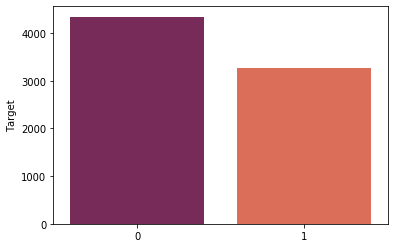

In [112]:
sns.barplot(train['Target'].value_counts().index, train['Target'].value_counts(), palette = 'rocket')

### Distribution of the Keyword column

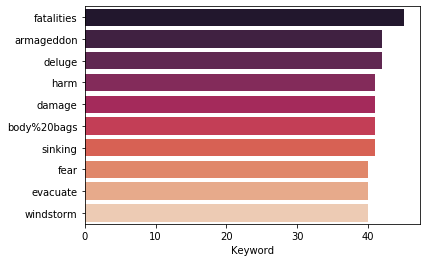

In [113]:
sns.barplot(y = train['Keyword'].value_counts()[:10].index, x = train['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

In [114]:
train.loc[train['Tweet text'].str.contains('disaster', na=False, case=False)].Target.value_counts()

1    102
0     40
Name: Target, dtype: int64

## 2. Test set

### Data loading

In [115]:
test = pd.read_csv('../data/test.csv')
test = test.sample(frac=1, replace=False)
test = test[['id', 'keyword', 'location', 'text']]
test.shape

(3263, 4)

In [116]:
test.columns = ['ID', 'Keyword', 'Location', 'Tweet text']
test.head()

,ID,Keyword,Location,Tweet text
3199,10634,wounded,Mii Facebook,Police Officer Wounded Suspect Dead After Exch...
1583,5358,fire,NaN,Politifiact: Harry Reid's '30 Percent of Women...
1305,4291,drowning,"Pico Rivera, CA",Drowning doesn't sound half bad rn
2396,8011,refugees,Kansas KS,'imagine an entire aisle dedicated to making p...
1991,6713,lava,NaN,Jordan Son of Mars - Hot Lava release on 07/22...


### Distribution of the Keyword column

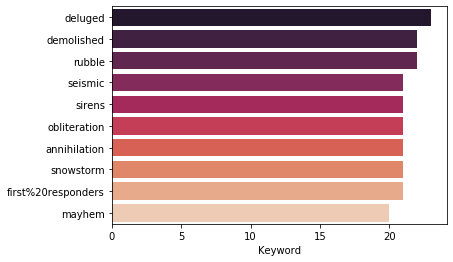

In [117]:
sns.barplot(y = test['Keyword'].value_counts()[:10].index, x = test['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

# III. Data preprocessing and tokenisation

In [118]:
# Applying a first round of text cleaning techniques
#Make text lowercase and remove text in square brackets, links, punctuation, words containing numbers.

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to the dataset
train['Tweet text'] = train['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
train['Tweet text'].head()

4012    love when drake floods instagram makes you fee...
2803    what the hell is wrong with peoplecommunicatio...
877     olrules welcome  read a free chapter of my new...
3762       daughterofnai tenshi activated yukis fire card
3531    monkeys abused by notorious laboratory dealer ...
Name: Tweet text, dtype: object

In [119]:
# Applying the cleaning function to the dataset
test['Tweet text'] = test['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
test['Tweet text'].head()

3199    police officer wounded suspect dead after exch...
1583    politifiact harry reids  percent of women serv...
1305                    drowning doesnt sound half bad rn
2396    imagine an entire aisle dedicated to making pe...
1991    jordan son of mars  hot lava release on  for  ...
Name: Tweet text, dtype: object

In [120]:
# Tokenising the training and test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['Tweet text'] = train['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
train['Tweet text'].head()

4012    [love, when, drake, floods, instagram, makes, ...
2803    [what, the, hell, is, wrong, with, peoplecommu...
877     [olrules, welcome, read, a, free, chapter, of,...
3762    [daughterofnai, tenshi, activated, yukis, fire...
3531    [monkeys, abused, by, notorious, laboratory, d...
Name: Tweet text, dtype: object

In [121]:
test['Tweet text'] = test['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
test['Tweet text'].head()

3199    [police, officer, wounded, suspect, dead, afte...
1583    [politifiact, harry, reids, percent, of, women...
1305             [drowning, doesnt, sound, half, bad, rn]
2396    [imagine, an, entire, aisle, dedicated, to, ma...
1991    [jordan, son, of, mars, hot, lava, release, on...
Name: Tweet text, dtype: object

In [122]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['Tweet text'] = train['Tweet text'].apply(lambda x : remove_stopwords(x))
train['Tweet text'].head()

4012    [love, drake, floods, instagram, makes, feel, ...
2803    [hell, wrong, peoplecommunication, rule, iron,...
877     [olrules, welcome, read, free, chapter, new, b...
3762    [daughterofnai, tenshi, activated, yukis, fire...
3531    [monkeys, abused, notorious, laboratory, deale...
Name: Tweet text, dtype: object

In [123]:
test['Tweet text'] = test['Tweet text'].apply(lambda x : remove_stopwords(x))
test['Tweet text'].head()

3199    [police, officer, wounded, suspect, dead, exch...
1583    [politifiact, harry, reids, percent, women, se...
1305             [drowning, doesnt, sound, half, bad, rn]
2396    [imagine, entire, aisle, dedicated, making, pe...
1991    [jordan, son, mars, hot, lava, release, via, k...
Name: Tweet text, dtype: object

A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

# IV. Classification models


## 1. KNN classifier
The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification (and also regression). In k-NN classification, The input consists of the k closest training examples in the feature space. The output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.

In [124]:
from sklearn.model_selection import train_test_split

X = train['Tweet text']
ylabels = train['Target']


print('X shape: ', X.shape)
print('y shape: ', y.shape)
X.head()

X shape:  (7613,)
y shape:  (3263, 4)


4012    [love, drake, floods, instagram, makes, feel, ...
2803    [hell, wrong, peoplecommunication, rule, iron,...
877     [olrules, welcome, read, free, chapter, new, b...
3762    [daughterofnai, tenshi, activated, yukis, fire...
3531    [monkeys, abused, notorious, laboratory, deale...
Name: Tweet text, dtype: object

In [125]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the training set
word_vectorizer = CountVectorizer()
X_train = word_vectorizer.fit_transform(train['Tweet text'].map(lambda words: ', '.join(words)))

# Vectorize the testing test
X_test = word_vectorizer.transform(test['Tweet text'].map(lambda words: ', '.join(words)))

# Our output variable "target" which indicates whether a tweet is diaster tweet
y_train = train['Target']

X_train.shape

(7613, 16222)

In [126]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

clf = BernoulliNB()
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

0.8003411140433389


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [127]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

scores = cross_val_score(knn, X_train, y_train)
print(scores.mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6802829221133629
